In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from step import msn, anba, util
from step import stats as st
from step import preprocessing as pp
from step.model import utility

import gpxpy
import pandas as pnd
import numpy as np
from datetime import timedelta

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

sns.set_style('ticks', {'axes.titlesize': 'large', 'legend.frameon': True});

%load_ext autoreload
%autoreload 2

%matplotlib notebook
matplotlib.rcParams['axes.labelsize'] = 'large'
matplotlib.rcParams['ytick.labelsize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 'medium'
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['legend.fancybox'] = True
matplotlib.rcParams['legend.edgecolor'] = 'black'
matplotlib.rcParams['legend.framealpha'] = 1.0
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['legend.markerscale'] = 0.8
matplotlib.rcParams['figure.figsize'] = (9, 3)
matplotlib.rcParams['axes.xmargin'] = 0.01
matplotlib.rcParams['axes.ymargin'] = 0.01
matplotlib.rcParams['axes.titlesize'] = 'large'
matplotlib.rcParams['figure.max_open_warning'] = 100

In [5]:
file_path = r'gpx/49996348-1533217229.gpx'
gpx = gpxpy.parse(open(file_path, 'r'))

In [7]:
#Ignore first 30 seconds (to avoid GPS "time to first fix")
gpx = pp.discard(gpx, timedelta(seconds=30))

movement_attributes = pp.get_movement_attributes(gpx)
df_all = pnd.DataFrame(movement_attributes, index=movement_attributes['timestamp'])

df = df_all[1:]

i_series = pnd.Series(np.arange(len(df)), index=df.index).rename('idx')
df = pnd.concat([df, i_series], axis=1)

df.head()

,acceleration,angle,distance,duration,elevation,heading,latitude,longitude,speed,timestamp,idx
2016-06-12 16:36:11,2.94,164.63,14.58,2,217,122,45.181206,5.734488,7.29,2016-06-12 16:36:11,0
2016-06-12 16:36:12,-0.67,84.25,10.23,1,217,106,45.181180,5.734613,10.23,2016-06-12 16:36:12,1
2016-06-12 16:36:26,0.51,155.30,11.92,14,216,202,45.181081,5.734556,0.85,2016-06-12 16:36:26,2
2016-06-12 16:36:30,-0.01,128.48,11.61,4,216,227,45.181009,5.734448,2.90,2016-06-12 16:36:30,3
2016-06-12 16:36:34,0.43,158.40,11.40,4,216,175,45.180907,5.734461,2.85,2016-06-12 16:36:34,4


## Elevation

In [8]:
elevation_data = df.elevation[:]

<IPython.core.display.Javascript object>


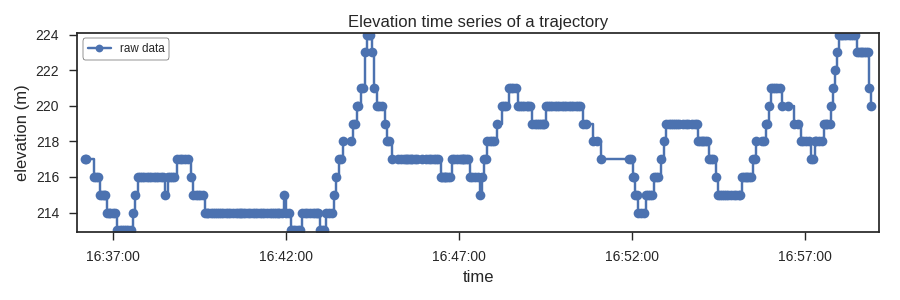

In [9]:
plt.figure()
plt.title("Elevation time series of a trajectory")
plt.xlabel('time')
plt.ylabel('elevation (m)')

plt.plot(elevation_data, 'o-', label='raw data', drawstyle='steps-post');
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc='best')
plt.tight_layout()

min_gvf = .5
min_dist = 1
min_time = np.percentile(df.time, 90)

anba_elevation = anba.anba(elevation_data, min_gvf, None, min_dist, min_time)

rmse = np.sqrt(((anba_elevation - elevation_data) ** 2).mean())
correlation = anba_elevation.corr(elevation_data)
seg = len(util.get_change_points(anba_elevation))-1

rmse, correlation, seg

plt.figure()

plt.plot(elevation_data, 'k:', label='data', alpha=1., drawstyle='steps-post')
plt.plot(anba_elevation, 'o-', label='ANBA approximation', drawstyle='steps-post');

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));

plt.legend(frameon=True, loc='best')
plt.tight_layout()

## Speed

In [10]:
noise_i = msn.get_noise(df)
stops_i = msn.get_stops(df)
noise_i, stops_i

(array([180]), array([222]))

In [11]:
series = df.speed[:]

speed_data = series.ewm(span=5).mean() #smoothed data
speed_data[noise_i] = None
speed_data[stops_i] = 0

<IPython.core.display.Javascript object>


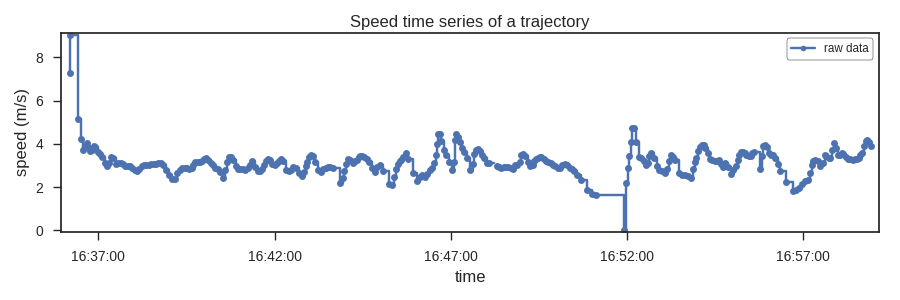

In [12]:
plt.figure()
plt.title("Speed time series of a trajectory")
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(speed_data, 'o-', ms=5, label='raw data', drawstyle='steps-post');
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc='best')
plt.tight_layout()

## Grade Adjusted Pace

https://github.com/andrewhao/stressfactor

https://github.com/andrewhao/stressfactor/blob/master/lib/stressfactor/grade_adjusted_pace_strategy.rb

http://www.runnersworld.com/races/downhill-all-the-way

http://labs.strava.com/blog/improving-grade-adjusted-pace/

In [13]:
def calculate_for_interval(interval_time, interval_distance, interval_grade):
    """
        interval_time in minutes
        interval_distance in kilometers
    """
    observed_pace = interval_time / interval_distance
    if interval_grade > 0: 
        return incline_pace(interval_grade, observed_pace)
    else:
        return decline_pace(interval_grade, observed_pace)
    
def decline_pace(grade, observed_pace):
    coefficient_per_grade_point = 0.01815
    return observed_pace / (1 - (coefficient_per_grade_point * grade))

def incline_pace(grade, observed_pace):
    coefficient_per_grade_point = 0.033
    return observed_pace / (1 + (coefficient_per_grade_point * grade))

<IPython.core.display.Javascript object>


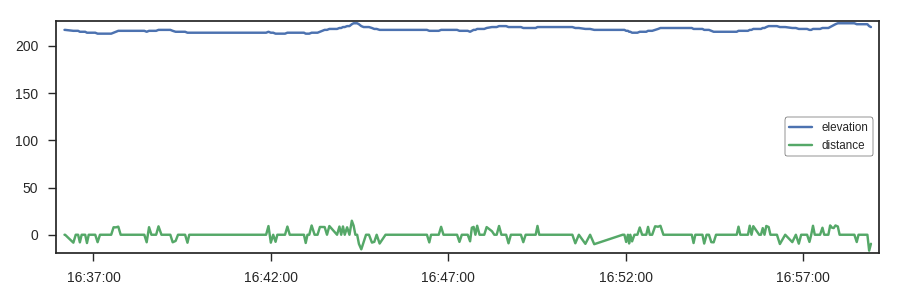

In [27]:
elevation_gain = np.ediff1d(df.elevation, to_begin=0)
grade = pnd.Series((elevation_gain/df.distance)*100, df.timestamp)
plt.figure()
plt.plot(df.elevation)
plt.plot(grade)
plt.legend(loc='best')
plt.tight_layout()

In [15]:
pace = pnd.Series([(1/s) * 16.67 if s != 0 else 0 for s in df.speed], df.timestamp)
#pace_time = [timedelta(minutes=p) for p in pace]
#[str(t) for t in pace_time]

#plt.figure()
#plt.plot(pace)
#plt.tight_layout()

In [17]:
time_min = df.duration/60
dist_km = df.distance/1000

grade_adjusted_pace = [calculate_for_interval(t, d, g) for t, d, g in zip(time_min, dist_km, grade)]
gap_series = pnd.Series(grade_adjusted_pace, df.timestamp)
gap_series = gap_series.ewm(span=5).mean() #smoothed data

gap_time = [timedelta(minutes=p) for p in gap_series]

#[str(t) for t in gap_time]

<IPython.core.display.Javascript object>


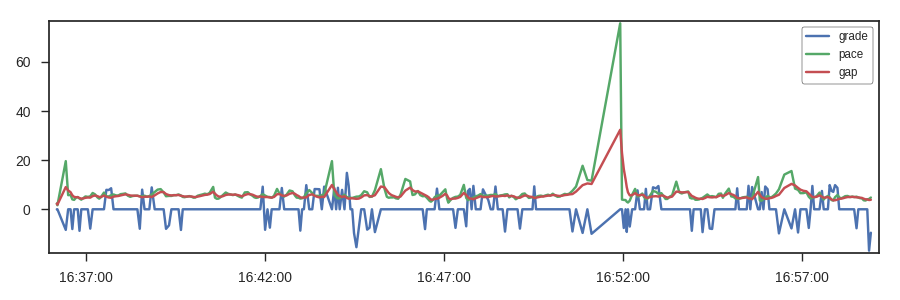

In [18]:
plt.figure()
plt.plot(grade, label='grade')
plt.plot(pace, label='pace')
plt.plot(gap_series, label='gap')
plt.legend()
plt.tight_layout()

In [20]:
min_gvf = .5
min_dist = 1
min_time = np.percentile(df.duration, 90)

anba_gap = anba.anba(gap_series, min_gvf, None, min_dist, min_time)

rmse = np.sqrt(((anba_gap - gap_series) ** 2).mean())
correlation = anba_gap.corr(gap_series)
seg = len(util.get_change_points(anba_gap))-1

rmse, correlation, seg

(4.100874417579365, 0.8790804408331786, 17)

<IPython.core.display.Javascript object>


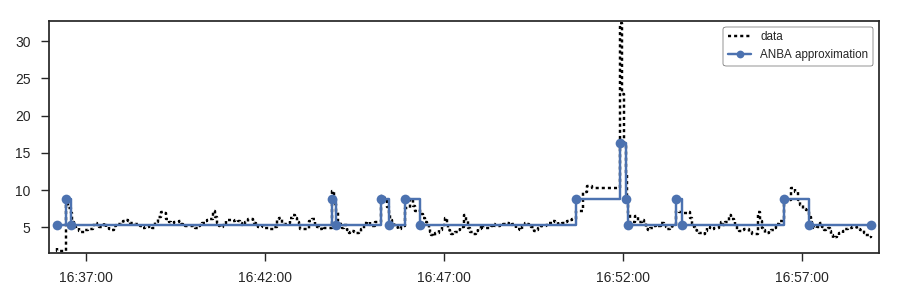

In [21]:
plt.figure()

plt.plot(gap_series, 'k:', label='data', alpha=1., drawstyle='steps-post')
plt.plot(anba_gap, 'o-', label='ANBA approximation', drawstyle='steps-post');

plt.legend(frameon=True, loc='best')
plt.tight_layout()

In [23]:
anba_gap #min/km (decimal format)

timestamp
2016-06-12 16:36:11     5.305858
2016-06-12 16:36:26     8.844276
2016-06-12 16:36:34     5.305858
2016-06-12 16:43:52     8.844276
2016-06-12 16:43:59     5.305858
2016-06-12 16:45:14     8.844276
2016-06-12 16:45:27     5.305858
2016-06-12 16:45:55     8.844276
2016-06-12 16:46:20     5.305858
2016-06-12 16:50:41     8.844276
2016-06-12 16:51:55    16.389392
2016-06-12 16:52:04     8.844276
2016-06-12 16:52:08     5.305858
2016-06-12 16:53:29     8.844276
2016-06-12 16:53:38     5.305858
2016-06-12 16:56:30     8.844276
2016-06-12 16:57:11     5.305858
2016-06-12 16:58:55     5.305858
dtype: float64

In [24]:
anba_gap_time = [timedelta(minutes=p) for p in anba_gap]
pnd.Series([str(t) for t in anba_gap_time], anba_gap.index)

timestamp
2016-06-12 16:36:11    0:05:18.351484
2016-06-12 16:36:26    0:08:50.656555
2016-06-12 16:36:34    0:05:18.351484
2016-06-12 16:43:52    0:08:50.656555
2016-06-12 16:43:59    0:05:18.351484
2016-06-12 16:45:14    0:08:50.656555
2016-06-12 16:45:27    0:05:18.351484
2016-06-12 16:45:55    0:08:50.656555
2016-06-12 16:46:20    0:05:18.351484
2016-06-12 16:50:41    0:08:50.656555
2016-06-12 16:51:55    0:16:23.363532
2016-06-12 16:52:04    0:08:50.656555
2016-06-12 16:52:08    0:05:18.351484
2016-06-12 16:53:29    0:08:50.656555
2016-06-12 16:53:38    0:05:18.351484
2016-06-12 16:56:30    0:08:50.656555
2016-06-12 16:57:11    0:05:18.351484
2016-06-12 16:58:55    0:05:18.351484
dtype: object

In [25]:
gap_foi = utility.series_to_foi('GradeAdjustedPace', anba_gap, gpx)

triples = gap_foi.triplify()

In [26]:
triples

[(rdflib.term.URIRef('http://example.com/resource/sMnudHbs'),
  rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label'),
  rdflib.term.Literal('GradeAdjustedPace', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string'))),
 (rdflib.term.URIRef('http://example.com/resource/sMnudHbs'),
  rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
  rdflib.term.URIRef('http://purl.org/net/step#FeatureOfInterest')),
 (rdflib.term.URIRef('http://example.com/resource/sMnudHbs'),
  rdflib.term.URIRef('http://purl.org/net/step#hasEpisode'),
  rdflib.term.URIRef('http://example.com/resource/5J6GLWyx')),
 (rdflib.term.URIRef('http://example.com/resource/5J6GLWyx'),
  rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
  rdflib.term.URIRef('http://purl.org/net/step#Episode')),
 (rdflib.term.URIRef('http://example.com/resource/5J6GLWyx'),
  rdflib.term.URIRef('http://purl.org/net/step#hasExtent'),
  rdflib.term.URIRef('http://example.com/resour